# Setup enviorment

In [ ]:
%cd ..

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_224_1024.csv'
embeddings_dir = 'Embeddings/'

labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [4]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043    2044  \
41001 201546 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201547 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201548 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201549 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201550 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.918507  -1.0 -0.861740  
      201547  -1.0 -0.918507  -1.0 -0.854589  
      201548  -1.0 -0.918507  -1.0 -0.856973  
      201549  -1.0 -0.918507  -1.0 -0.856973  
      201550  -1.0 -0.918507  -1.0 -0.823600  

[5 rows x 2049 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4    5         6    7  \
5360 201546 -1.0 -1.000000 -0.965792 -0.570709 -0.950769 -1.0 -1.000000 -1.0   
     201547 -1.0 -1.000000 -0.420975 -1.000000 -1.000000 -1.0 -1.000000 -1.0   
     201548 -1.0 -1.000000 -0.965792 -0.570709 -0.950769 -1.0 -1.000000 -1.0   
     201549 -1.0 -0.988155 -0.337508 -1.000000 -0.844715 -1.0 -0.998583 -1.0   
     201550 -1.0 -1.000000 -0.965792 -0.570709 -0.950769 -1.0 -1.000000 -1.0   

               8         9  ...     2039      2040      2041  2042      2043  \
5360 201546 -1.0 -0.902422  ... -1.00000 -0.900735 -0.809416  -1.0 -1.000000   
     201547 -1.0 -1.000000  ... -0.86945 -0.774895 -1.000000  -1.0 -0.918301   
     201548 -1.0 -0.902422  ... -1.00000 -0.900735 -0.809416  -1.0 -1.000000   
     201549 -1.0 -0.662333  ... -1.00000 -0.762259 -1.000000  -1.0 -0.977865   
     201550 -1.0 -0.902422  ... -1.00000 -0.900735 -0.809416  -1.0 -1.000000   

               2044  2045      2046  2047    Labels  
5360 201546 -0.5034  -1.0 -0.918507  -1.0 -0.990465  
     201547 -1.0000  -1.0 -0.848083  -1.0 -0.969011  
     201548 -0.5034  -1.0 -0.918507  -1.0 -0.995232  
     201549 -1.0000  -1.0 -0.879277  -1.0 -0.997616  
     201550 -0.5034  -1.0 -0.918507  -1.0 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [10]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

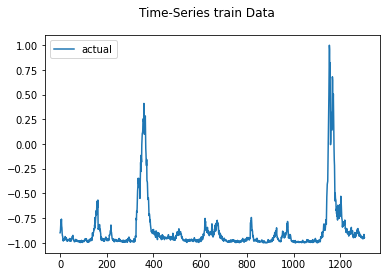

2023-03-04 23:51:26.695521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 23:51:26.695565: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 23:51:26.695588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-04 23:51:26.695777: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 23:51:26.868738: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 43.236
Test sMAPE: 134.219
Test RMSE: 53.718
{'mae': 43.23578519186725, 'smape': 134.219033429988, 'rmse': 53.71819795995963}


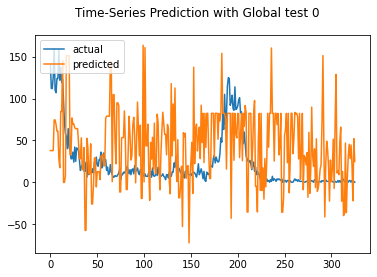

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 40.280
Test sMAPE: 126.770
Test RMSE: 48.583
{'mae': 40.279731701488146, 'smape': 126.76998132958639, 'rmse': 48.58326342322671}


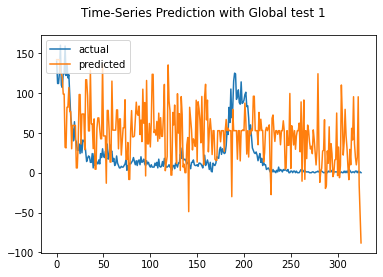

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 58.724
Test sMAPE: 145.175
Test RMSE: 71.811
{'mae': 58.72437057283027, 'smape': 145.1754800882999, 'rmse': 71.81092343810175}


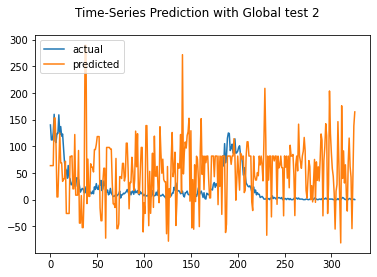

Test MAE: 158.627
Test sMAPE: 165.924
Test RMSE: 180.763
{'mae': 158.6267262441249, 'smape': 165.9241525327755, 'rmse': 180.7627166651518}


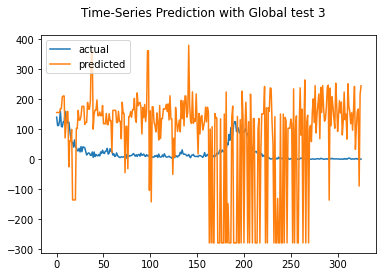

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 43.596
Test sMAPE: 129.157
Test RMSE: 53.242
{'mae': 43.59621810602264, 'smape': 129.15664411951883, 'rmse': 53.24158876566265}


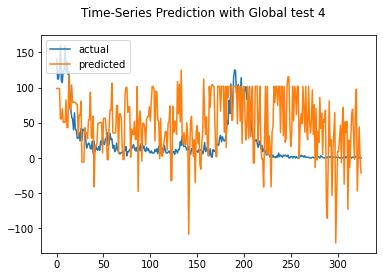

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 43.955
Test sMAPE: 127.124
Test RMSE: 52.868
{'mae': 43.95527157827389, 'smape': 127.12444783684735, 'rmse': 52.86817718788768}


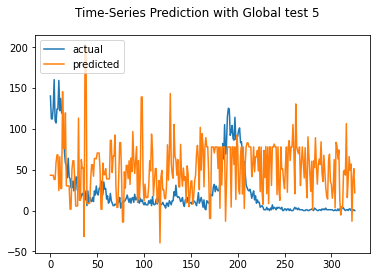

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 56.775
Test sMAPE: 138.262
Test RMSE: 69.938
{'mae': 56.77534021336608, 'smape': 138.2615119315636, 'rmse': 69.93767086489095}


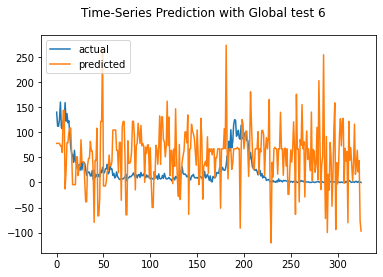

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 51.564
Test sMAPE: 132.529
Test RMSE: 61.260
{'mae': 51.563549975950295, 'smape': 132.5286558781836, 'rmse': 61.260375028516094}


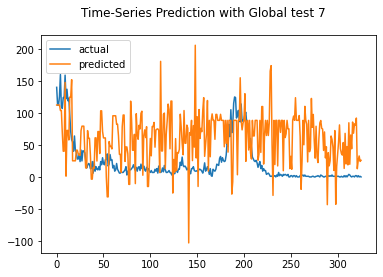

Test MAE: 105.620
Test sMAPE: 149.609
Test RMSE: 158.955
{'mae': 105.62046960563016, 'smape': 149.60920106930192, 'rmse': 158.95521405632817}


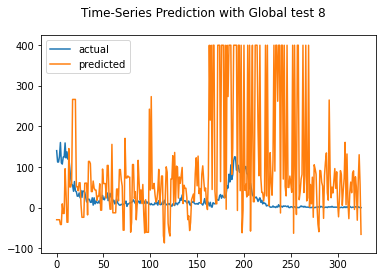

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 48.217
Test sMAPE: 134.178
Test RMSE: 56.729
{'mae': 48.217174661762876, 'smape': 134.17785283657116, 'rmse': 56.72945601660396}


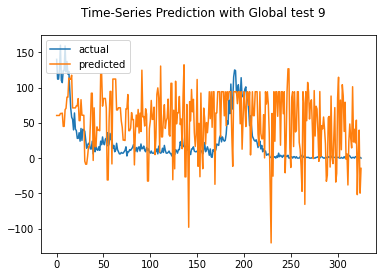

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 47.545
Test sMAPE: 136.904
Test RMSE: 59.397
{'mae': 47.54479656665603, 'smape': 136.90391704792435, 'rmse': 59.39725810042601}


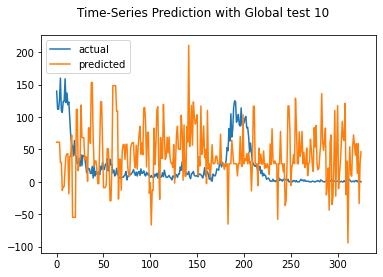

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 52.507
Test sMAPE: 154.129
Test RMSE: 68.086
{'mae': 52.50747183404086, 'smape': 154.12919601917247, 'rmse': 68.08568475588305}


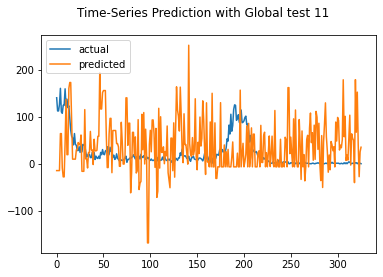

Test MAE: 76.530
Test sMAPE: 142.094
Test RMSE: 90.808
{'mae': 76.52959659348237, 'smape': 142.0937528680214, 'rmse': 90.80820757349194}


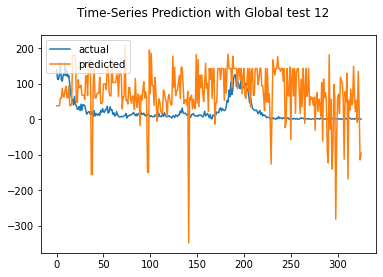

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 54.685
Test sMAPE: 133.374
Test RMSE: 67.309
{'mae': 54.68526488981364, 'smape': 133.37405396557293, 'rmse': 67.30868623962886}


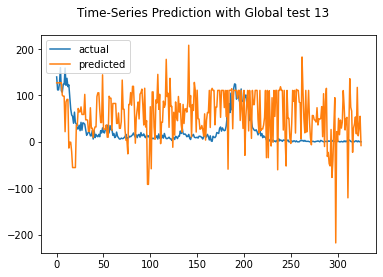

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 56.454
Test sMAPE: 138.105
Test RMSE: 74.995
{'mae': 56.45365459019421, 'smape': 138.10481314351878, 'rmse': 74.9954244734203}


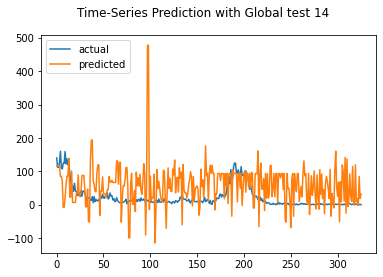

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 69.752
Test sMAPE: 139.328
Test RMSE: 81.321
{'mae': 69.75232485540074, 'smape': 139.3277264006957, 'rmse': 81.32106440489935}


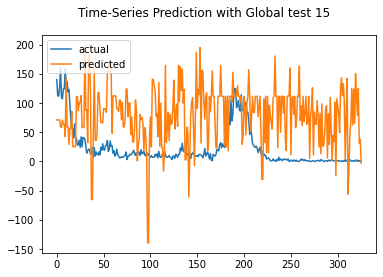

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 46.302
Test sMAPE: 126.871
Test RMSE: 55.666
{'mae': 46.301998189621905, 'smape': 126.87057469720837, 'rmse': 55.66636060736772}


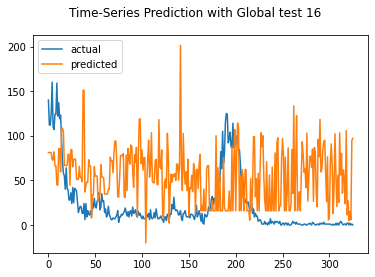

Test MAE: 85.828
Test sMAPE: 164.526
Test RMSE: 118.786
{'mae': 85.82821921958514, 'smape': 164.52584418562537, 'rmse': 118.7857077216672}


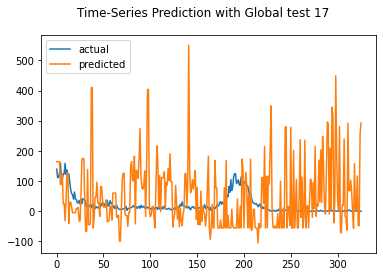

Test MAE: 59.794
Test sMAPE: 146.956
Test RMSE: 70.418
{'mae': 59.79383293251318, 'smape': 146.95609848167896, 'rmse': 70.41788585382825}


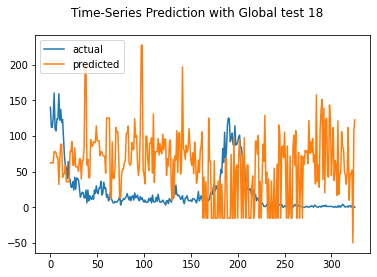

Test MAE: 49.890
Test sMAPE: 133.128
Test RMSE: 65.326
{'mae': 49.8902000603866, 'smape': 133.12783733360678, 'rmse': 65.32596119975092}


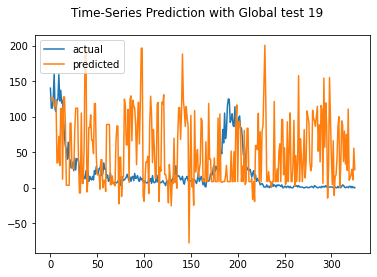

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 60.662
Test sMAPE: 138.757
Test RMSE: 71.980
{'mae': 60.66151606616067, 'smape': 138.7568931998955, 'rmse': 71.9800722323062}


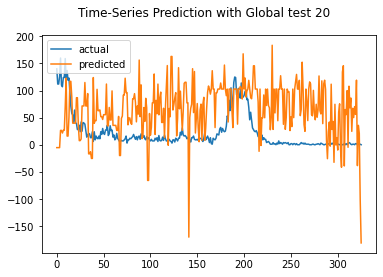

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 48.944
Test sMAPE: 132.315
Test RMSE: 56.197
{'mae': 48.943882394422054, 'smape': 132.31480308700344, 'rmse': 56.19744793365454}


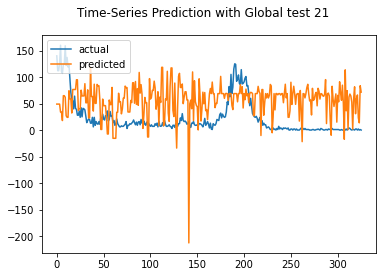

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 64.083
Test sMAPE: 136.820
Test RMSE: 75.306
{'mae': 64.08298740732523, 'smape': 136.81952261115953, 'rmse': 75.30645769614212}


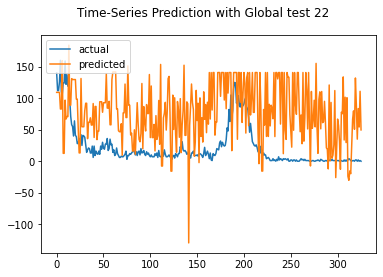

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 38.714
Test sMAPE: 131.909
Test RMSE: 47.814
{'mae': 38.713551194755574, 'smape': 131.90876996713789, 'rmse': 47.81419265148941}


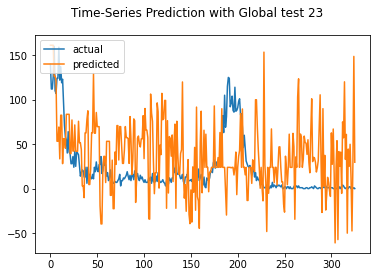

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 38.099
Test sMAPE: 128.974
Test RMSE: 47.645
{'mae': 38.09890354429286, 'smape': 128.97358503948308, 'rmse': 47.64548423447615}


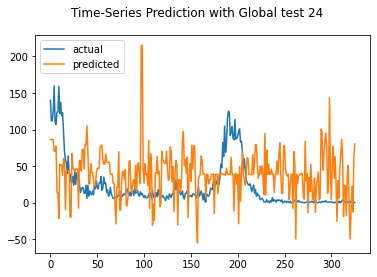

Test MAE: 48.122
Test sMAPE: 129.816
Test RMSE: 58.565
{'mae': 48.12190057986353, 'smape': 129.81581010651342, 'rmse': 58.56455237832941}


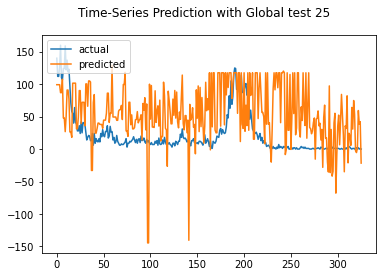

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 49.958
Test sMAPE: 131.539
Test RMSE: 58.152
{'mae': 49.95808777048544, 'smape': 131.5390264404978, 'rmse': 58.15217556496561}


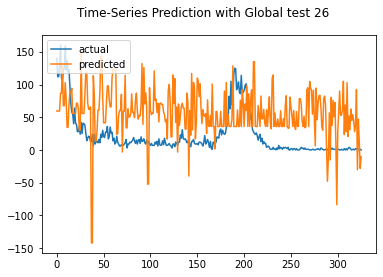

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 57.271
Test sMAPE: 134.558
Test RMSE: 67.094
{'mae': 57.27088359162851, 'smape': 134.55816385941145, 'rmse': 67.0942717134028}


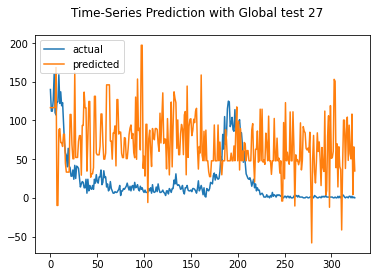

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 46.855
Test sMAPE: 133.558
Test RMSE: 56.757
{'mae': 46.85521317195673, 'smape': 133.55793158426698, 'rmse': 56.75712249090155}


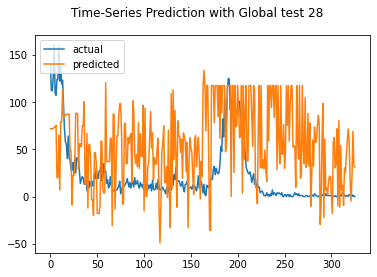

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.306
Test sMAPE: 130.648
Test RMSE: 56.417
{'mae': 47.306177376603785, 'smape': 130.64796001467795, 'rmse': 56.417193408232855}


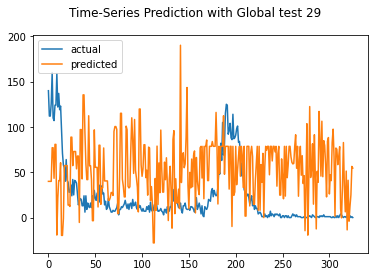

Test MAE: 52.557
Test sMAPE: 130.930
Test RMSE: 62.259
{'mae': 52.557160751037074, 'smape': 130.92951340256258, 'rmse': 62.25872931264185}


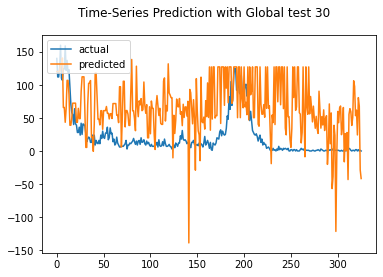

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 53.928
Test sMAPE: 148.954
Test RMSE: 70.410
{'mae': 53.92834176424822, 'smape': 148.9542806331153, 'rmse': 70.4098894920544}


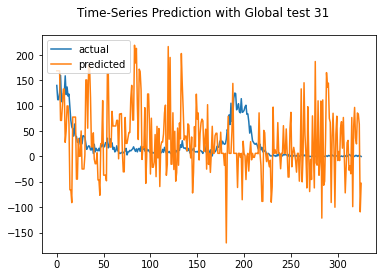

Test MAE: 68.029
Test sMAPE: 153.817
Test RMSE: 82.731
{'mae': 68.02892487217312, 'smape': 153.8174747351124, 'rmse': 82.73089317615577}


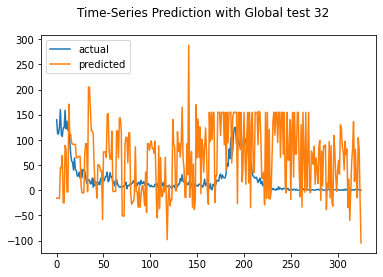

Test MAE: 45.539
Test sMAPE: 123.483
Test RMSE: 60.032
{'mae': 45.538635743907626, 'smape': 123.48336732385447, 'rmse': 60.031844412681814}


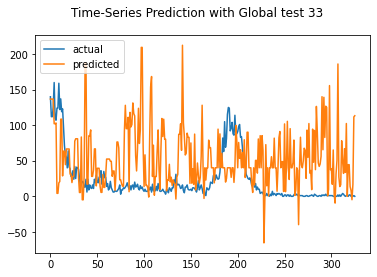

Test MAE: 41.214
Test sMAPE: 132.890
Test RMSE: 49.347
{'mae': 41.21443668794047, 'smape': 132.89023877435557, 'rmse': 49.34706916912242}


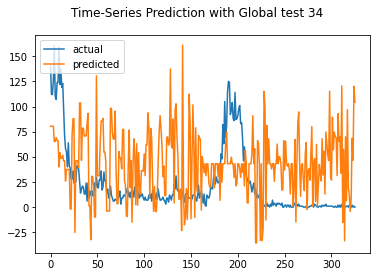

Test MAE: 71.559
Test sMAPE: 158.242
Test RMSE: 88.045
{'mae': 71.55900759199646, 'smape': 158.24186154917393, 'rmse': 88.044617510897}


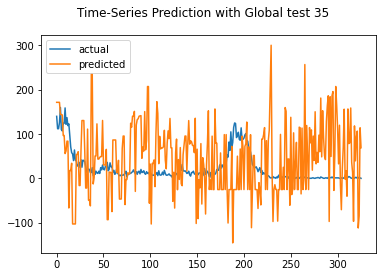

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 63.354
Test sMAPE: 141.440
Test RMSE: 76.319
{'mae': 63.35364042789293, 'smape': 141.43976264133866, 'rmse': 76.31899160504827}


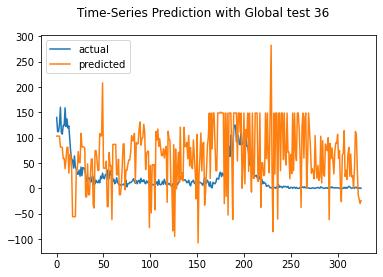

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 49.001
Test sMAPE: 128.339
Test RMSE: 56.585
{'mae': 49.001064373945894, 'smape': 128.3393310331386, 'rmse': 56.584666167457556}


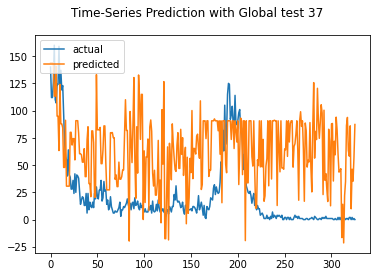

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 40.594
Test sMAPE: 142.906
Test RMSE: 52.418
{'mae': 40.59388630960617, 'smape': 142.9056854693291, 'rmse': 52.41789786672052}


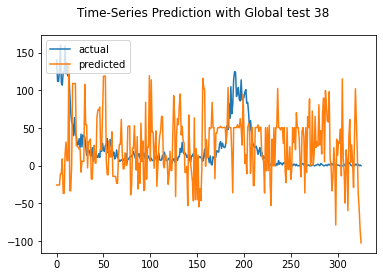

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 63.179
Test sMAPE: 149.629
Test RMSE: 78.135
{'mae': 63.179027019468556, 'smape': 149.62870015183094, 'rmse': 78.13453567175942}


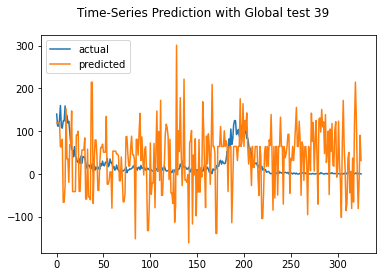

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 54.306
Test sMAPE: 130.326
Test RMSE: 68.698
{'mae': 54.30626919883892, 'smape': 130.32626787467984, 'rmse': 68.69756936372526}


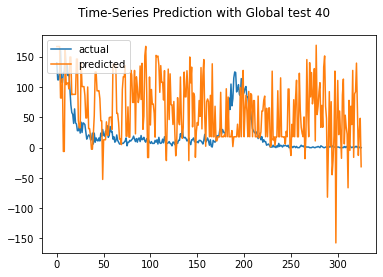

Test MAE: 70.823
Test sMAPE: 140.035
Test RMSE: 92.019
{'mae': 70.82277024889285, 'smape': 140.03520990361844, 'rmse': 92.0188965009099}


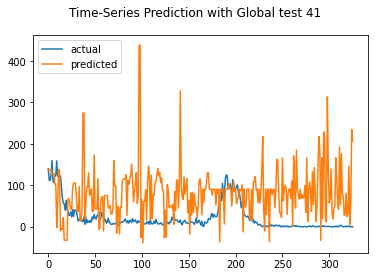

Test MAE: 101.604
Test sMAPE: 155.985
Test RMSE: 117.721
{'mae': 101.60351472215419, 'smape': 155.98525317416994, 'rmse': 117.72071362084807}


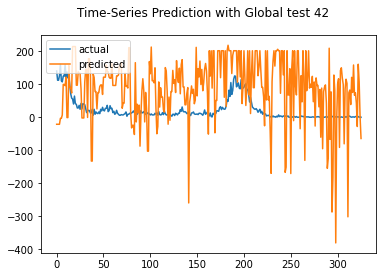

Test MAE: 43.684
Test sMAPE: 142.664
Test RMSE: 56.979
{'mae': 43.68444770848824, 'smape': 142.66384881516584, 'rmse': 56.97921860719974}


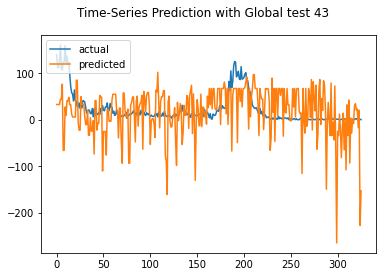

Test MAE: 78.387
Test sMAPE: 143.091
Test RMSE: 90.365
{'mae': 78.38655151545636, 'smape': 143.09093118297852, 'rmse': 90.36512352258137}


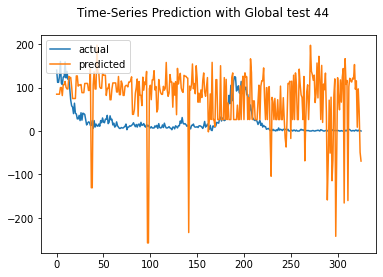

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 66.275
Test sMAPE: 139.641
Test RMSE: 80.013
{'mae': 66.2749447813429, 'smape': 139.6412991459437, 'rmse': 80.0131552115682}


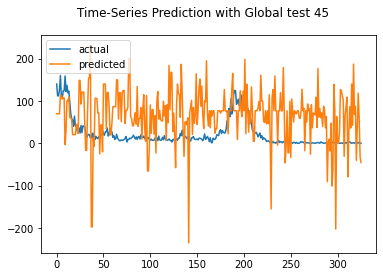

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 43.953
Test sMAPE: 127.750
Test RMSE: 51.196
{'mae': 43.952609467725814, 'smape': 127.74950506898342, 'rmse': 51.19551184501847}


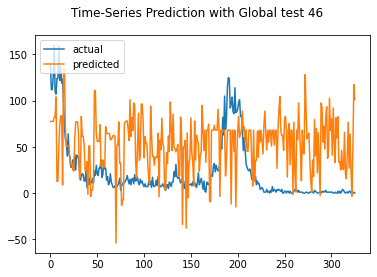

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 57.600
Test sMAPE: 136.270
Test RMSE: 65.402
{'mae': 57.59960362808836, 'smape': 136.26976374545168, 'rmse': 65.40156221972391}


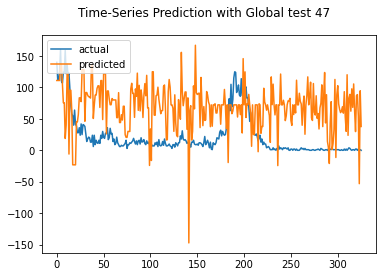

Test MAE: 100.880
Test sMAPE: 146.720
Test RMSE: 126.685
{'mae': 100.88008103268278, 'smape': 146.72049853491603, 'rmse': 126.68511280657137}


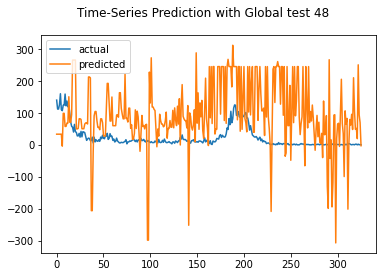

Test MAE: 52.107
Test sMAPE: 125.710
Test RMSE: 69.740
{'mae': 52.106621255538215, 'smape': 125.70959663979914, 'rmse': 69.7399129748599}


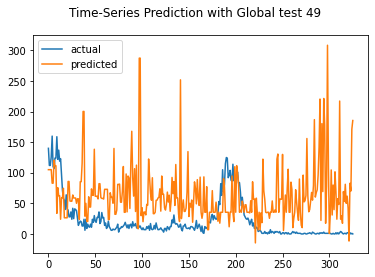

Test MAE: 70.582
Test sMAPE: 134.172
Test RMSE: 116.698
{'mae': 70.5818361707626, 'smape': 134.17214367884057, 'rmse': 116.69784291693647}


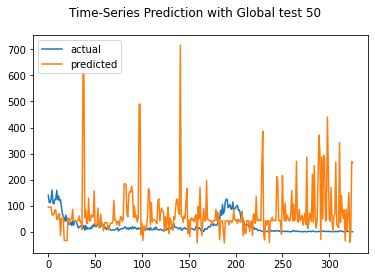

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 44.861
Test sMAPE: 137.306
Test RMSE: 57.630
{'mae': 44.861019503119536, 'smape': 137.30578164649646, 'rmse': 57.62951222159677}


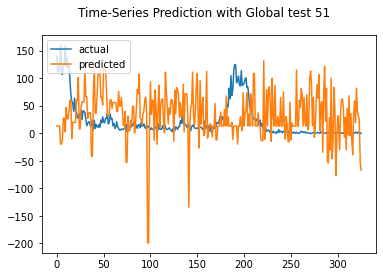

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 44.541
Test sMAPE: 130.559
Test RMSE: 57.435
{'mae': 44.54107863460582, 'smape': 130.55947658211426, 'rmse': 57.43464652589424}


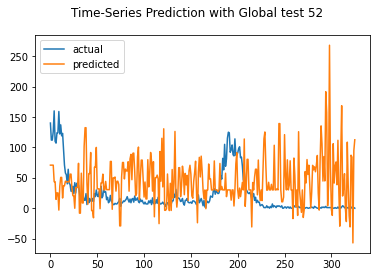

Test MAE: 49.521
Test sMAPE: 128.832
Test RMSE: 57.217
{'mae': 49.521018246200185, 'smape': 128.8321664822308, 'rmse': 57.216660394349155}


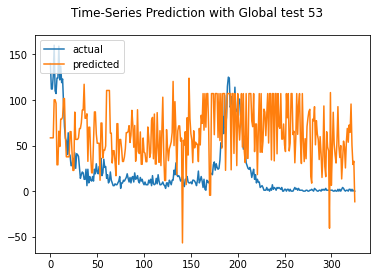

Test MAE: 190.731
Test sMAPE: 188.729
Test RMSE: 231.584
{'mae': 190.7306889754497, 'smape': 188.7294456459974, 'rmse': 231.58411120992486}


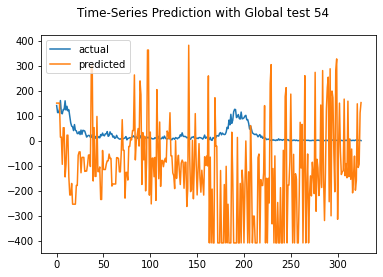

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 52.889
Test sMAPE: 138.324
Test RMSE: 65.993
{'mae': 52.88945673671237, 'smape': 138.3240991744227, 'rmse': 65.99331463697698}


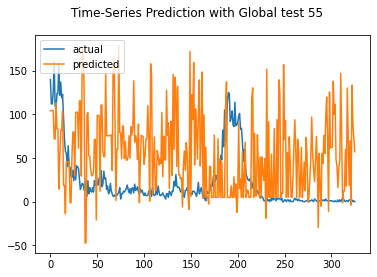

Test MAE: 60.335
Test sMAPE: 137.845
Test RMSE: 71.305
{'mae': 60.334706051218, 'smape': 137.84452608033044, 'rmse': 71.3047299254978}


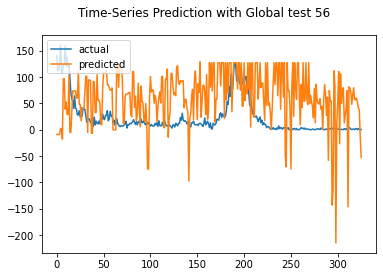

Test MAE: 51.431
Test sMAPE: 129.255
Test RMSE: 67.274
{'mae': 51.43062906323767, 'smape': 129.254530393398, 'rmse': 67.27382998783537}


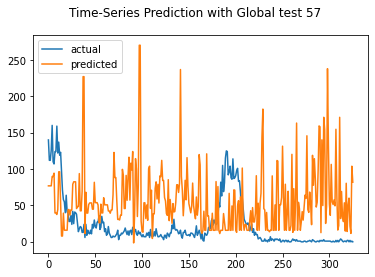

Test MAE: 69.575
Test sMAPE: 144.627
Test RMSE: 90.589
{'mae': 69.57463966364875, 'smape': 144.6274045666476, 'rmse': 90.58880613014357}


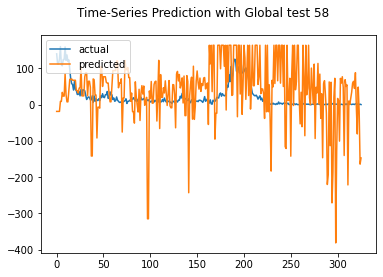

Test MAE: 56.432
Test sMAPE: 132.760
Test RMSE: 68.852
{'mae': 56.43179693525554, 'smape': 132.76025317220538, 'rmse': 68.85174713233931}


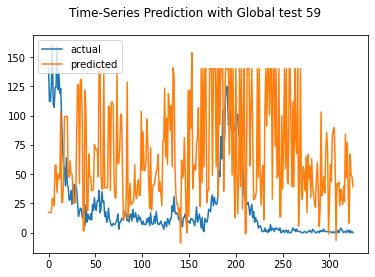

Test MAE: 46.587
Test sMAPE: 126.369
Test RMSE: 58.283
{'mae': 46.58732650031342, 'smape': 126.36941707384652, 'rmse': 58.28298674689178}


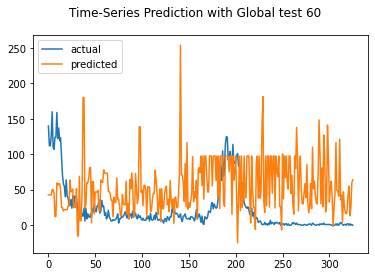

Test MAE: 82.557
Test sMAPE: 146.233
Test RMSE: 114.034
{'mae': 82.55650324872666, 'smape': 146.23346007124238, 'rmse': 114.03423804426447}


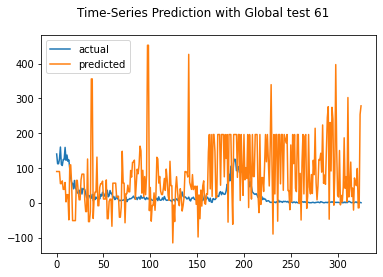

Test MAE: 90.080
Test sMAPE: 142.804
Test RMSE: 110.069
{'mae': 90.08049225075844, 'smape': 142.80445101570123, 'rmse': 110.06907330304647}


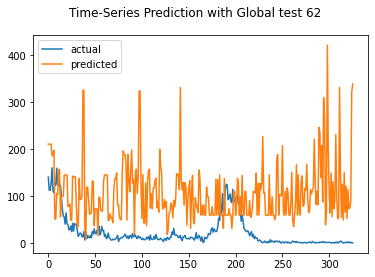

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 63.551
Test sMAPE: 139.391
Test RMSE: 72.835
{'mae': 63.550933412978985, 'smape': 139.39104451576034, 'rmse': 72.83466205225763}


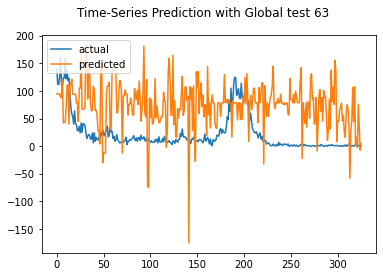

Test MAE: 101.019
Test sMAPE: 160.627
Test RMSE: 117.616
{'mae': 101.01863749407552, 'smape': 160.62718049496013, 'rmse': 117.6160153613793}


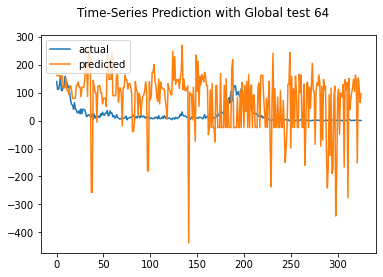

Test MAE: 97.980
Test sMAPE: 144.541
Test RMSE: 138.836
{'mae': 97.98031449884725, 'smape': 144.5407804149955, 'rmse': 138.8363894203319}


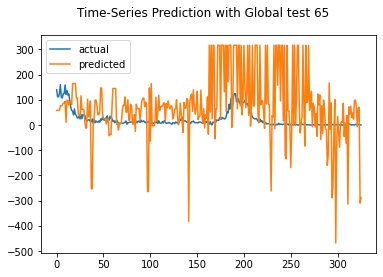

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 48.557
Test sMAPE: 132.794
Test RMSE: 58.793
{'mae': 48.556798003202566, 'smape': 132.79431576464702, 'rmse': 58.79313032374651}


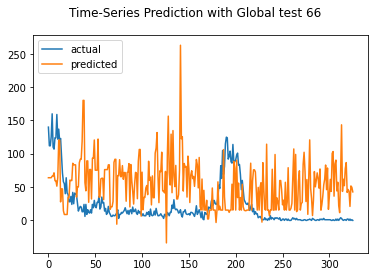

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 55.511
Test sMAPE: 143.966
Test RMSE: 68.177
{'mae': 55.51115629259794, 'smape': 143.96568249362136, 'rmse': 68.17680464786154}


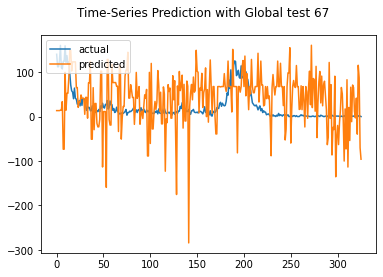

Test MAE: 90.963
Test sMAPE: 146.418
Test RMSE: 106.829
{'mae': 90.96251405199612, 'smape': 146.41805128096325, 'rmse': 106.82879052270822}


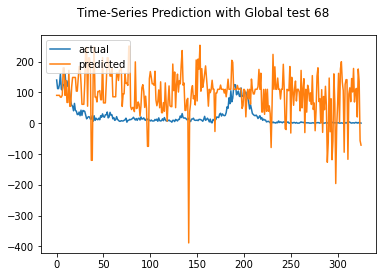

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 47.719
Test sMAPE: 134.451
Test RMSE: 56.266
{'mae': 47.71933377173049, 'smape': 134.45100789332963, 'rmse': 56.26576188393212}


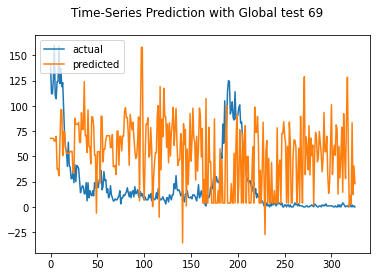

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 53.504
Test sMAPE: 134.243
Test RMSE: 67.117
{'mae': 53.5036146949771, 'smape': 134.24335436799507, 'rmse': 67.11744877459059}


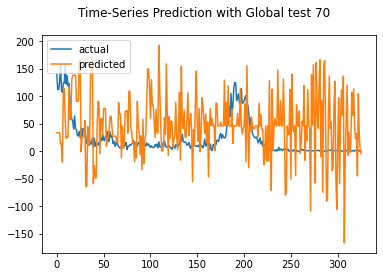

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 46.767
Test sMAPE: 128.757
Test RMSE: 54.239
{'mae': 46.76710528683809, 'smape': 128.75656827115398, 'rmse': 54.23915995196468}


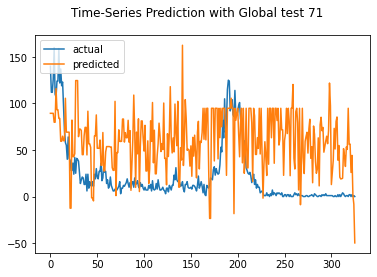

Test MAE: 82.994
Test sMAPE: 156.225
Test RMSE: 105.081
{'mae': 82.99403162977082, 'smape': 156.2250697355428, 'rmse': 105.08078882473447}


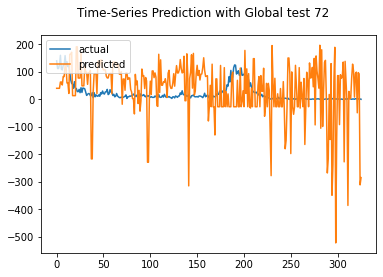

Test MAE: 52.095
Test sMAPE: 131.680
Test RMSE: 63.099
{'mae': 52.095017870511015, 'smape': 131.67970732076662, 'rmse': 63.0992301888024}


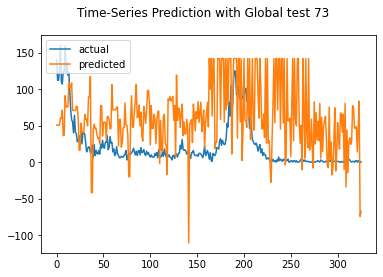

Test MAE: 56.604
Test sMAPE: 136.042
Test RMSE: 62.916
{'mae': 56.604428253108004, 'smape': 136.04165857536913, 'rmse': 62.91608484702892}


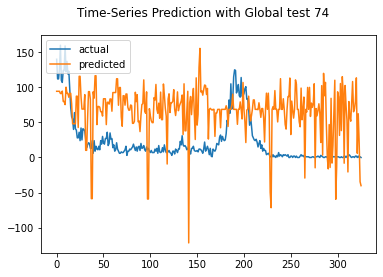

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 60.756
Test sMAPE: 137.952
Test RMSE: 74.393
{'mae': 60.75631369257266, 'smape': 137.95203552027684, 'rmse': 74.39282932108705}


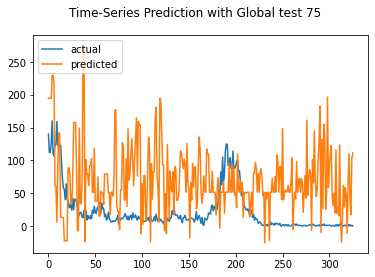

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 47.446
Test sMAPE: 128.340
Test RMSE: 56.190
{'mae': 47.445534396390975, 'smape': 128.34007084524396, 'rmse': 56.18971982285317}


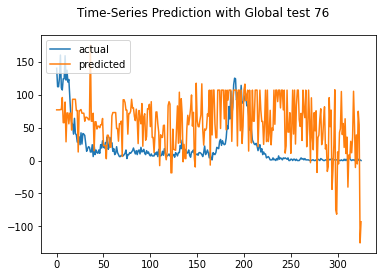

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 56.475
Test sMAPE: 149.576
Test RMSE: 66.837
{'mae': 56.474654897590355, 'smape': 149.57649486062942, 'rmse': 66.8365370466883}


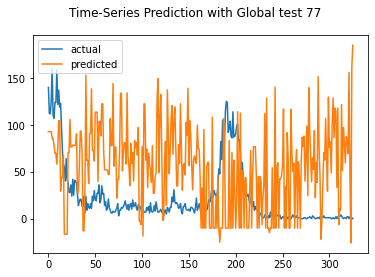

Test MAE: 66.264
Test sMAPE: 134.843
Test RMSE: 80.914
{'mae': 66.26373256715529, 'smape': 134.84317661677454, 'rmse': 80.91446914020123}


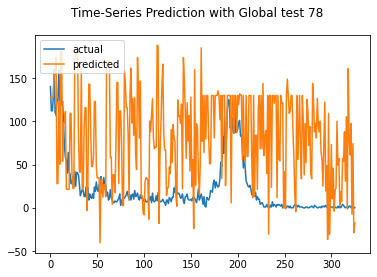

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 50.645
Test sMAPE: 129.059
Test RMSE: 59.135
{'mae': 50.644520332476844, 'smape': 129.05924121645373, 'rmse': 59.134698578001306}


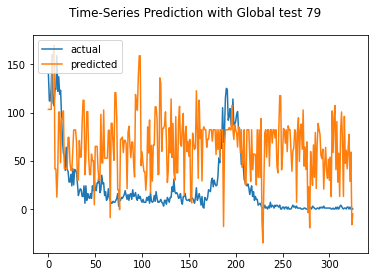

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 53.052
Test sMAPE: 132.475
Test RMSE: 63.784
{'mae': 53.052008384941544, 'smape': 132.47496084816652, 'rmse': 63.783670706850856}


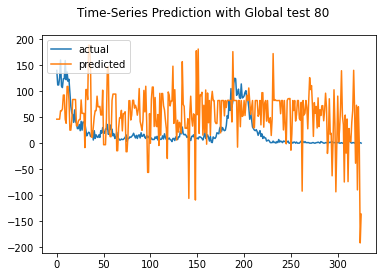

Test MAE: 56.755
Test sMAPE: 133.233
Test RMSE: 69.338
{'mae': 56.75532171843242, 'smape': 133.23276310565828, 'rmse': 69.33824974307345}


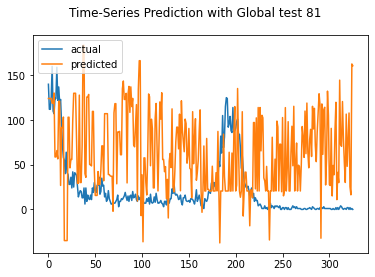

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 50.797
Test sMAPE: 137.837
Test RMSE: 64.911
{'mae': 50.79674375825133, 'smape': 137.8370175605366, 'rmse': 64.91082472632951}


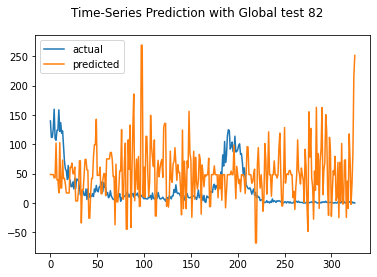

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 40.441
Test sMAPE: 126.481
Test RMSE: 51.592
{'mae': 40.44132017961309, 'smape': 126.48122670792884, 'rmse': 51.5918003545863}


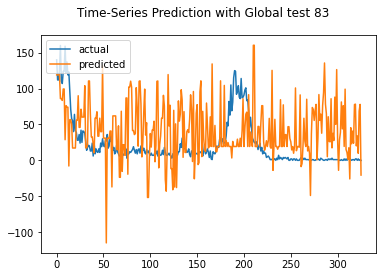

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 47.882
Test sMAPE: 137.693
Test RMSE: 62.918
{'mae': 47.88197853649321, 'smape': 137.6934829143737, 'rmse': 62.91766549646795}


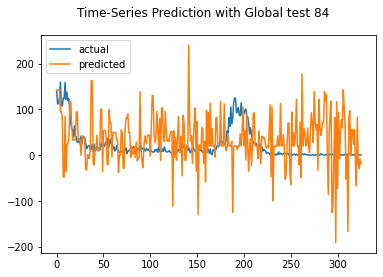

Test MAE: 66.721
Test sMAPE: 140.309
Test RMSE: 74.483
{'mae': 66.72106061756976, 'smape': 140.30913388846147, 'rmse': 74.48262200459565}


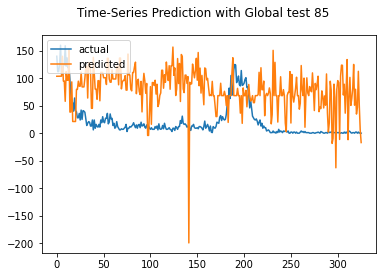

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 47.038
Test sMAPE: 132.052
Test RMSE: 59.151
{'mae': 47.037580491392156, 'smape': 132.05177021006236, 'rmse': 59.150605336625176}


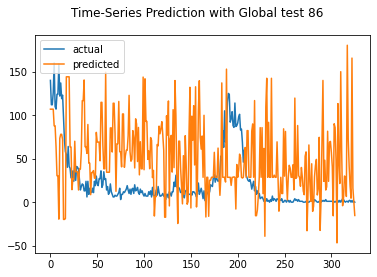

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 51.825
Test sMAPE: 141.978
Test RMSE: 65.849
{'mae': 51.824915070840916, 'smape': 141.97823686871348, 'rmse': 65.84913085316622}


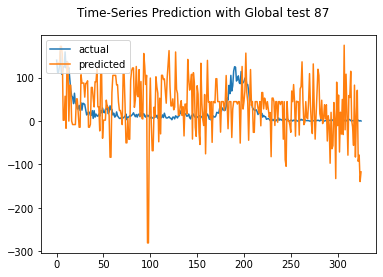

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 48.366
Test sMAPE: 141.853
Test RMSE: 63.230
{'mae': 48.36583116431178, 'smape': 141.85301521768275, 'rmse': 63.229817952825194}


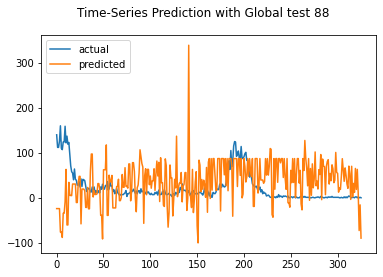

Test MAE: 65.963
Test sMAPE: 137.129
Test RMSE: 76.904
{'mae': 65.96300639842917, 'smape': 137.12893600081316, 'rmse': 76.9044472367164}


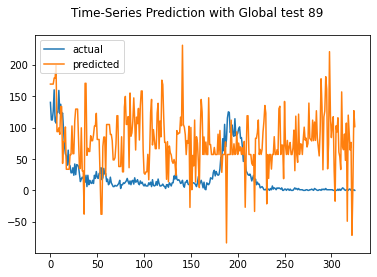

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 53.966
Test sMAPE: 137.361
Test RMSE: 67.887
{'mae': 53.96597656351657, 'smape': 137.36070633549033, 'rmse': 67.88652511815917}


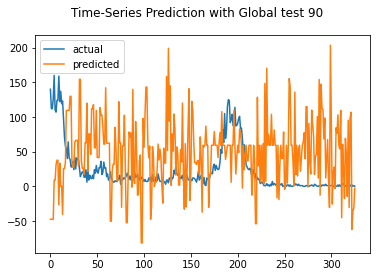

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 58.427
Test sMAPE: 139.627
Test RMSE: 72.925
{'mae': 58.4266764311337, 'smape': 139.6273583311457, 'rmse': 72.92504786457583}


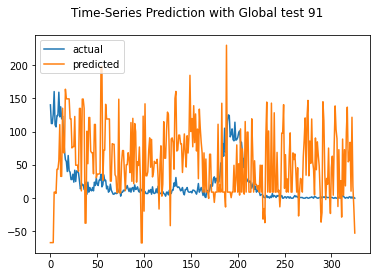

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 43.294
Test sMAPE: 130.641
Test RMSE: 51.554
{'mae': 43.29359876835273, 'smape': 130.6405715805539, 'rmse': 51.553910655892274}


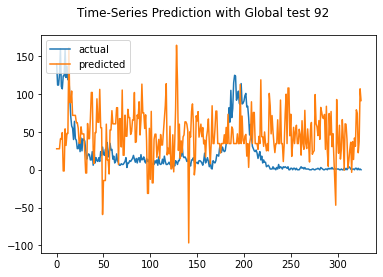

Test MAE: 83.874
Test sMAPE: 146.902
Test RMSE: 112.982
{'mae': 83.87414831252185, 'smape': 146.9018353352883, 'rmse': 112.98208009660448}


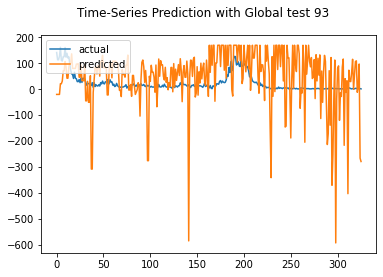

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 58.181
Test sMAPE: 136.815
Test RMSE: 74.358
{'mae': 58.1810146058264, 'smape': 136.81476212684217, 'rmse': 74.35814487369086}


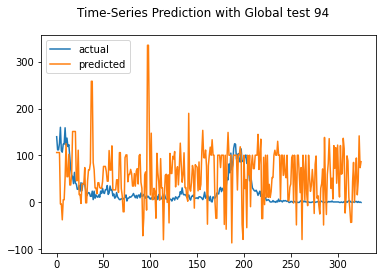

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 53.665
Test sMAPE: 131.704
Test RMSE: 62.926
{'mae': 53.664760614831025, 'smape': 131.70375327592467, 'rmse': 62.926173897211}


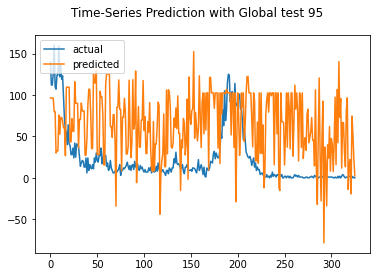

Test MAE: 60.738
Test sMAPE: 138.266
Test RMSE: 69.524
{'mae': 60.73836350002172, 'smape': 138.26592925406374, 'rmse': 69.52449932580326}


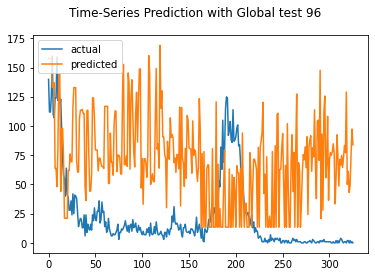

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 55.470
Test sMAPE: 131.223
Test RMSE: 65.133
{'mae': 55.4700861249599, 'smape': 131.22337867880486, 'rmse': 65.13301783817184}


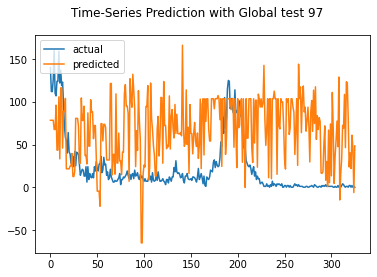

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.069
Test sMAPE: 130.937
Test RMSE: 55.107
{'mae': 47.069133056819076, 'smape': 130.93740868151392, 'rmse': 55.10719292660645}


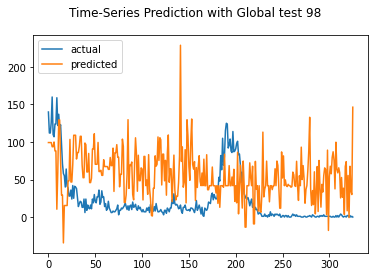

Test MAE: 75.948
Test sMAPE: 152.850
Test RMSE: 83.609
{'mae': 75.94829388483902, 'smape': 152.8498868759994, 'rmse': 83.60857585503294}


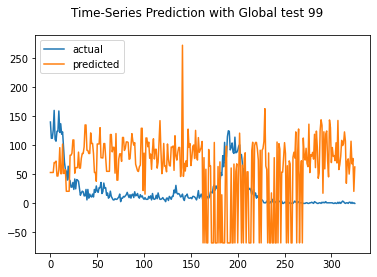

rmse : average=74.954, std=28.317
mae : average=60.769, std=22.340
smape : average=138.502, std=10.176


([74.95402728444991, 28.31734326956454],
 [60.76908291091856, 22.340264151639484],
 [138.50164360475208, 10.176133077144508])

In [12]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
